# 物件偵測範例: 怎麼讀取私有資料，以Traffic Sign為範例

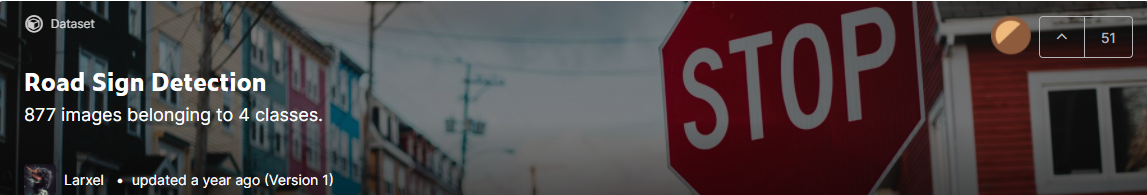

<font size=4>首先先到[kaggle的Road Sign Detection](https://www.kaggle.com/andrewmvd/road-sign-detection)下載資料。 <br>
下載好後，將資料放到預設資料夾下的**./dataset/stopsign**資料夾內。 <br>

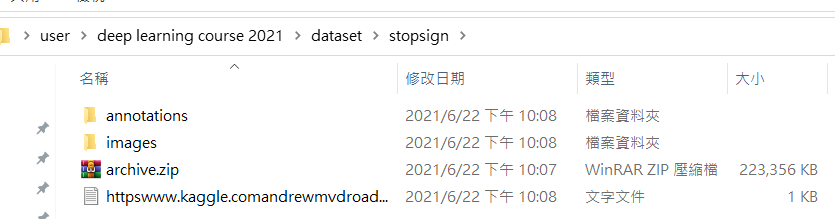
    
    
此資料內含有877張影像，裡面有四種不同類跌的道路交通號誌，分別為
</font>

|類別|0|1|2|3|
|:---:|:---:|:---:|:---:|:---:|
|名稱|Trafic Light|Stop|Speedlimit|Crosswalk|
    
<font size=4>
    Bounding Box標註是依據PASCAL VOC 格式。
</font>



<font size=4>
    我們先將資料夾內的所有圖片檔案名稱和路徑全部列出來
    

In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
anno_path = Path('./dataset/stopsign/annotations')
annotations = filelist(anno_path, '.xml')
print('總共有多少標註檔案:{}'.format(len(annotations)))
print('我們將前10筆印出來看一下')
for i in range(10):
    print(annotations[i])

總共有多少標註檔案:877
我們將前10筆印出來看一下
dataset\stopsign\annotations\road0.xml
dataset\stopsign\annotations\road1.xml
dataset\stopsign\annotations\road10.xml
dataset\stopsign\annotations\road100.xml
dataset\stopsign\annotations\road101.xml
dataset\stopsign\annotations\road102.xml
dataset\stopsign\annotations\road103.xml
dataset\stopsign\annotations\road104.xml
dataset\stopsign\annotations\road105.xml
dataset\stopsign\annotations\road106.xml


<font size=4 color=#0000FF> **將"dataset\stopsign\annotations\road0.xml" 打開來看一下** <br> </font>
<font size=4>PASCAL VOC 格式:<br>

```xml
<annotation>
    <folder>images</folder>
    <filename>road0.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>62</ymin>
            <xmax>208</xmax>
            <ymax>232</ymax>
        </bndbox>
    </object>
</annotation>
```

<font size=5 color='block'> **我們用xml.etree.ElementTree來試看看怎麼進行xml parser** </font>

<font size=4> <br>
    
xml為層級關係，
- annotation
 - folder
 - filename
 - size
 - segmented
 - object
   - name : 物件類別，下圖為Stop sign。
   - pose : 標記用，比如在車輛四周裝設鏡頭，可以在這邊標記說他是front，表示是前鏡頭拍的，一般都不太會用到，以Unspecified。
   - truncated: 0或是1，表示物件有沒有因為被遮蔽而被截斷。
   - occluded:  0或是1，表示此物件是不是有重要的部分被擋住。
   - difficult: 0或是1，表示此物件是不是因為很難被辨識，視覺上物件可能很清楚，但無法知道是屬於哪個類別等，標記為difficult則在評比的時候就不會納入計算成績用。
   - bndbox: 該物件的座標
     - xmin: 見下圖
     - ymin: 見下圖
     - xmax: 見下圖
     - ymax: 見下圖


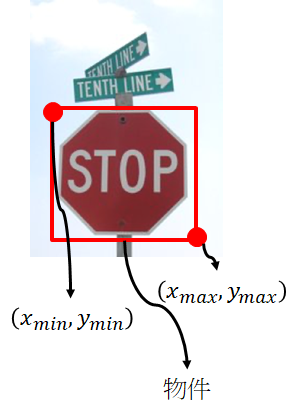

我們用 'dataset\stopsign\annotations\road0.xml' 作為範例，示範怎麼進行xml parser

In [2]:
annotation=annotations[0]
images_path = Path('./dataset/stopsign/images')
###############
root = ET.parse(annotation).getroot()
filename = Path(str(images_path) + '/' + root.find("./filename").text)
labelname = root.find("./object/name").text
xmin = int(root.find("./object/bndbox/xmin").text)
ymin = int(root.find("./object/bndbox/ymin").text)
xmax = int(root.find("./object/bndbox/xmax").text)
ymax = int(root.find("./object/bndbox/ymax").text)
bbox = [xmin,ymin,xmax,ymax]
flag_isimage=os.path.isfile(filename)
print('imagefile:{}'.format(filename))
print('imagefile exits:{}'.format(flag_isimage))
print('ObjectName:{}'.format(labelname))
print('Bounding Box:[xmin,ymin,xmax,ymax]=[{},{},{},{}]'.format(xmin,ymin,xmax,ymax))

imagefile:dataset\stopsign\images\road0.png
imagefile exits:True
ObjectName:trafficlight
Bounding Box:[xmin,ymin,xmax,ymax]=[98,62,208,232]


<font size=5 color='block'> **所以我們利用上面的xml parser將所有的標註檔案進行數據初始化，將所有圖片的filepath和Bounding Box座標和類別都記錄下來在一個list。** </font>

In [3]:
labelmap = {'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 4}

images_path = Path('./dataset/stopsign/images')
###############
root = ET.parse(annotation).getroot()

def xml_parser(xml_filepath):
    root = ET.parse(xml_filepath).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    flag_isimage=os.path.isfile(filename)
    if flag_isimage:
        bboxes=[]
        labels=[]
        for object_xml in root.iter('object'):
            label = object_xml.find('name').text.lower()
            bbox = object_xml.find('bndbox')
            xmin = int(bbox.find("xmin").text) 
            ymin = int(bbox.find("ymin").text) 
            xmax = int(bbox.find("xmax").text) 
            ymax = int(bbox.find("ymax").text) 
            bbox = [xmin,ymin,xmax,ymax]
            bboxes.append(bbox)
            labels.append(labelmap[label])
        return filename, bboxes, labels
    else:
        return [],[],[]

def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs, labels = xml_parser(anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

imagepaths, bboxes = generate_data_inf(annotations)
for i in range(2):
    print('image path:{}'.format(imagepaths[i]))
    print('bbox:{}, label:{}'.format(bboxes[i][1],bboxes[i][0]))



image path:dataset\stopsign\images\road0.png
bbox:[[98, 62, 208, 232]], label:[1]
image path:dataset\stopsign\images\road1.png
bbox:[[154, 63, 258, 281]], label:[1]


<font size=4>
    找幾張圖片畫出圖片和Boundary box框。</font>

image shape:(400, 267, 3)
bbox:[[98, 62, 208, 232]]
label:[1]


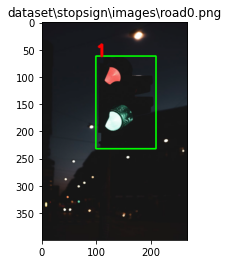

image shape:(225, 400, 3)
bbox:[[310, 29, 369, 79]]
label:[2]


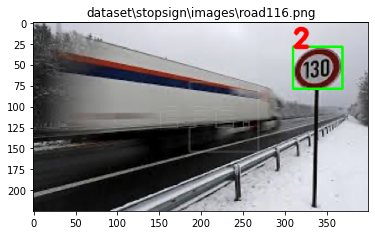

image shape:(400, 300, 3)
bbox:[[91, 122, 141, 179], [157, 202, 172, 225]]
label:[3, 3]


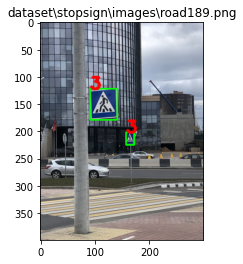

In [4]:
for data_id in [0,20,100]:
    im = cv2.imread(str(imagepaths[data_id]))
    bbs = bboxes[data_id][1]
    labels = bboxes[data_id][0]
    print('image shape:{}'.format(im.shape))
    print('bbox:{}'.format(bbs))
    print('label:{}'.format(labels))
    imageplot=im.copy()
    for bb, label in zip(bbs, labels):
        cv2.rectangle(imageplot,(bb[0],bb[1]),(bb[2],bb[3]),(0,255,0),2)
        cv2.putText(imageplot, str(label), (bb[0],bb[1]), 0, 1, (0, 0, 255), 4, cv2.LINE_AA)
    imageplot = cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB)
    plt.imshow(imageplot)
    plt.title(str(imagepaths[data_id]))
    plt.show()

# cv2.imshow('image', imageplot)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## pandas寫法 (Kaggle範例寫的，但有問題，原因是他每張圖只能處理一個Bounding Box)

In [5]:
import pandas as pd

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

images_path = Path('./dataset/stopsign/images')
anno_path = Path('./dataset/stopsign/annotations')
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,dataset\stopsign\images\road0.png,267,400,trafficlight,98,62,208,232
1,dataset\stopsign\images\road1.png,400,283,trafficlight,154,63,258,281
2,dataset\stopsign\images\road10.png,400,267,trafficlight,106,3,244,263
3,dataset\stopsign\images\road100.png,400,385,speedlimit,35,5,363,326
4,dataset\stopsign\images\road101.png,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,dataset\stopsign\images\road95.png,300,400,stop,90,101,268,257
873,dataset\stopsign\images\road96.png,400,267,stop,209,58,326,179
874,dataset\stopsign\images\road97.png,400,267,stop,42,66,130,154
875,dataset\stopsign\images\road98.png,400,267,stop,138,17,376,245


In [6]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [7]:
class_dict = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,dataset\stopsign\images\road0.png,267,400,0,98,62,208,232
1,dataset\stopsign\images\road1.png,400,283,0,154,63,258,281
2,dataset\stopsign\images\road10.png,400,267,0,106,3,244,263
3,dataset\stopsign\images\road100.png,400,385,1,35,5,363,326
4,dataset\stopsign\images\road101.png,400,200,1,195,7,392,194


image shape:(400, 267, 3)
bbox:[32 73 148 191]


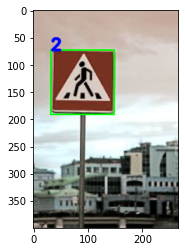

In [8]:
data_id = 50
im = cv2.imread(str(df_train.values[data_id][0]))
bb = df_train.values[data_id][4:8]
label = df_train.values[data_id][3]
print('image shape:{}'.format(im.shape))
print('bbox:{}'.format(bb))

imageplot=im.copy()
cv2.rectangle(imageplot,(bb[0],bb[1]),(bb[2],bb[3]),(0,255,0),2)
cv2.putText(imageplot, str(label), (bb[0],bb[1]), 0, 1, (0, 0, 255), 4, cv2.LINE_AA)

plt.imshow(imageplot)

# cv2.imshow('image', targetImage)
# cv2.waitKey(0)
# cv2.destroyAllWindows()